# **Assignment 6: Policy Evaluation with TD(0)**

Welcome to Assignment 6! In this task, you'll create a reinforcement learning agent designed for prediction, specifically utilizing a foundational model-free method known as one-step temporal difference learning, or TD(0). Your main objective will be to build an agent capable of policy evaluation within the Cliff Walking environment. As a quick reminder, policy evaluation involves predicting and accurately estimating state values under a given policy.

### **Learning Objectives**
- Develop components of the Cliff Walking environment to gain practical experience defining Markov Decision Processes (MDPs) [Section 1].
- Create an agent leveraging bootstrapping methods, specifically implementing the TD(0) algorithm [Section 2].
- Conduct experiments by applying TD(0) to evaluate value functions across various policies [Section 3].


## **The Cliff Walking Environment**

The Cliff Walking environment is a discrete gridworld scenario characterized by a finite state and action space. The agent begins each episode at the designated start cell (S). At each step, the agent can deterministically move to one of its four neighboring cells by selecting from the actions: Up, Down, Left, or Right. Attempting to move beyond the grid boundaries leaves the agent in its current position. For instance, if the agent attempts to move left from a cell located in the leftmost column, it will remain in the same cell without moving.

The environment provides a reward structure designed to penalize each step taken by the agent:

- A reward of **-1** for each standard step taken.
- A penalty of **-100** if the agent falls off the cliff (stepping into a cliff cell).

This task is episodic, meaning the episode ends once the agent reaches the goal cell (G). However, if the agent falls off the cliff, it incurs the penalty and is reset to the start position (S), but the episode continues without termination.

The diagram below visually summarizes the environment setup and illustrates two example policies that we will evaluate.

<img src="./img/cliffwalk.png" style="height:400px">

## **Packages**

We import the following essential libraries required for this assignment:

1. **jdc**: Jupyter magic extension enabling the definition of classes across multiple notebook cells.
2. **numpy**: The fundamental library for scientific computing in Python.
3. **matplotlib**: A comprehensive library for creating visualizations and graphs.
4. **RL-Glue**: A framework library designed specifically for reinforcement learning experiments.
5. **BaseEnvironment, BaseAgent**: Base classes used to create customized environment and agent classes compatible with the RL-Glue framework.
6. **Manager**: Facilitates visualization and comprehensive testing.
8. **tqdm.tqdm**: Provides intuitive progress bars for visual tracking of loop execution.

In [1]:
!unzip lab6.zip

Archive:  lab6.zip
  inflating: Lab6-Policy Evaluation with TD Learning/img/cliffwalk-annotated.png  
  inflating: Lab6-Policy Evaluation with TD Learning/img/cliffwalk.png  
  inflating: Lab6-Policy Evaluation with TD Learning/assignment6.ipynb  
  inflating: Lab6-Policy Evaluation with TD Learning/env/manager.py  
  inflating: Lab6-Policy Evaluation with TD Learning/env/optimal_policy_value_fn.npy  
  inflating: Lab6-Policy Evaluation with TD Learning/env/__pycache__/rl_glue.cpython-311.pyc  
  inflating: Lab6-Policy Evaluation with TD Learning/env/__pycache__/manager.cpython-311.pyc  
  inflating: Lab6-Policy Evaluation with TD Learning/env/rl_glue.py  
  inflating: Lab6-Policy Evaluation with TD Learning/env/safe_policy_value_fn.npy  
  inflating: Lab6-Policy Evaluation with TD Learning/env/__pycache__/Agent.cpython-311.pyc  
  inflating: Lab6-Policy Evaluation with TD Learning/env/__pycache__/Environment.cpython-311.pyc  
  inflating: Lab6-Policy Evaluation with TD Learning/env/Ag

In [3]:
pip install jdc

In [5]:
import jdc
import numpy as np
from env.rl_glue import RLGlue
from env.Agent import BaseAgent
from env.Environment import BaseEnvironment
from env.manager import Manager
from tqdm import tqdm

## **Section 1: Cliff Walking Environment**

In this first part of the assignment, you'll explore and implement key components of the Cliff Walking environment, gaining practical insight into how Markov Decision Processes (MDPs) are structured and executed.

Specifically, you will implement the following functionalities:

1. **Coordinate Conversion**: Converting 2-dimensional grid coordinates into a single linear state index.
2. **Action Logic**: Implementing the logic for the "move up" action.
3. **Reward and Termination Conditions**: Defining conditions for receiving rewards and recognizing terminal states.

Below is an annotated diagram detailing the structure of the environment, which should guide you through your implementation. Although the environment will allow for flexible dimensions, the start, goal, and cliff positions always maintain consistent relative placements—start at the bottom-left corner, goal at the bottom-right corner, and cliff cells filling the bottom row between the start and goal cells.

<img src="./img/cliffwalk-annotated.png" style="height:400px">

The following code defines a Python class `CliffWalkEnvironment` as a template for modeling a reinforcement learning environment, specifically the Cliff Walk scenario. It inherits from a base class (`BaseEnvironment`) and includes placeholder methods (`env_init`, `env_start`, `env_step`, `env_cleanup`, and `state`) that need implementation. Each method currently raises `NotImplementedError`, indicating they will be defined later to manage environment interactions, such as initializing states, handling actions, and transitioning states during episodes.

In [6]:
# Cliff Walk Environment Class Template

# Define the CliffWalkEnvironment class inheriting from BaseEnvironment.
# The methods defined here serve as placeholders and will be implemented later.
class CliffWalkEnvironment(BaseEnvironment):

    # Initialize the environment with given parameters.
    def env_init(self, env_info={}):
        raise NotImplementedError

    # Starts a new episode, returning the initial state.
    def env_start(self):
        raise NotImplementedError

    # Executes a given action and returns the resulting state, reward, and completion status.
    def env_step(self, action):
        raise NotImplementedError

    # Cleans up the environment after episode completion.
    def env_cleanup(self):
        raise NotImplementedError

    # Helper method to convert location into environment state representation.
    def state(self, loc):
        raise NotImplementedError


### **env_init()**

The first function we add to the environment is the initialization function which is called once an environment object is created. In this function, the grid dimensions and special locations (start and goal locations and the cliff locations) are stored for easy use later.

In [7]:
%%add_to CliffWalkEnvironment

# Environment Initialization Function for Cliff Walk
def env_init(self, env_info={}):
    """Initializes the Cliff Walk environment at the start of an experiment.

    Args:
        env_info (dict): Contains environment configuration parameters such as grid dimensions.

    Note:
        Initializes a tuple holding the reward, initial state, and termination indicator.
        These are reinitialized in `env_start()` for each episode.
    """

    # Initialize placeholders for reward, state, and termination flag.
    reward = None
    state = None  # Placeholder for state observation
    termination = None
    self.reward_state_term = (reward, state, termination)

    # Set grid dimensions; default height is 4 and width is 12, aligning with standard Cliff Walk setup.
    self.grid_h = env_info.get("grid_height", 4)
    self.grid_w = env_info.get("grid_width", 12)

    # Define coordinate system:
    # Positive x-direction is downward; positive y-direction is to the right (row-major NumPy convention).

    # Starting location is the bottom-left corner (maximum x, minimum y).
    self.start_loc = (self.grid_h - 1, 0)

    # Goal location is the bottom-right corner (maximum x, maximum y).
    self.goal_loc = (self.grid_h - 1, self.grid_w - 1)

    # Define cliff as the row of cells between start_loc and goal_loc.
    self.cliff = [(self.grid_h - 1, y) for y in range(1, self.grid_w - 1)]

### **Implement state()**
    
The agent location can be described as a two-tuple or coordinate (x, y) describing the agent's position. However, we can convert the (x, y) tuple into a single index and provide agents with just this integer. One reason for this choice is that the spatial aspect of the problem is secondary and there is no need for the agent to know about the exact dimensions of the environment.
From the agent's viewpoint, it is just perceiving some states, accessing their corresponding values in a table, and updating them. Both the coordinate (x, y) state representation and the converted coordinate representation are thus equivalent in this sense.

Given a grid cell location, the state() function should return the state; a single index corresponding to the location in the grid.

**Example:** Suppose grid_h is 2 and grid_w is 2. Then, we can write the grid cell two-tuple or coordinate states as follows (following the usual 0-index convention):
|(0, 0) (0, 1)| |0 1|
|(1, 0) (1, 1)| |2 3|
Assuming row-major order as NumPy does, we can flatten the latter to get a vector [0 1 2 3]. So, if loc = (0, 0) we return 0. While, for loc = (1, 1) we return 3.


In [8]:
%%add_to CliffWalkEnvironment

# Helper Function: Convert 2D Grid Location to 1D State Index
def state(self, loc):
    """Converts a 2D grid location (x, y) into a single-dimensional state index.

    Args:
        loc (tuple): The (x, y) location coordinates on the grid.

    Returns:
        int: A single-dimensional index representing the given grid location.
    """
    # Convert (row, column) coordinates to single-dimensional state representation
    # Using row-major order: state = row * width + column
    return loc[0] * self.grid_w + loc[1]


In [9]:
# Test and Debugging for Cliff Walk Environment State Conversion

# Instantiate the CliffWalkEnvironment object.
env = CliffWalkEnvironment()

# Initialize the environment with specified grid dimensions (height=4, width=12).
env.env_init({"grid_height": 4, "grid_width": 12})

# Define test coordinates and their corresponding correct state indices.
coords = [(0, 0), (0, 11), (1, 5), (3, 0), (3, 9), (3, 11)]
correct_outputs = [0, 11, 17, 36, 45, 47]

# Convert test coordinates using the state function and store results.
got = [env.state(s) for s in coords]

# Verify correctness of state conversion by comparing against known correct outputs.
assert got == correct_outputs  # Assertion will raise error if there is a mismatch.

### **env_start()**

In env_start(), we initialize the agent location to be the start location and return the state corresponding to it as the first state for the agent to act upon. Additionally, we also set the reward and termination terms to be 0 and False respectively as they are consistent with the notion that there is no reward nor termination before the first action is even taken.

In [10]:
%%add_to CliffWalkEnvironment

# Start Episode in Cliff Walk Environment
def env_start(self):
    """Initializes the environment state at the beginning of each episode.

    This method sets the initial reward, agent location, state representation, and termination status.

    Returns:
        int: The initial state represented as a single-dimensional index.
    """
    # Initialize starting reward to 0 at the beginning of the episode.
    reward = 0

    # Set the agent's initial position to the predefined starting location.
    self.agent_loc = self.start_loc

    # Convert the agent's initial 2D location to a single-dimensional state index.
    state = self.state(self.agent_loc)

    # Initialize termination flag to False, indicating the episode has just begun.
    termination = False

    # Store the initial reward, state, and termination status in a tuple.
    self.reward_state_term = (reward, state, termination)

    # Return the initial state index.
    return state

### **Implement env_step()**

Once an action is taken by the agent, the environment must provide a new state, reward and termination signal.

In the Cliff Walking environment, agents move around using a 4-cell neighborhood called the Von Neumann neighborhood (https://en.wikipedia.org/wiki/Von_Neumann_neighborhood). Thus, the agent has 4 available actions at each state. Three of the actions have been implemented for you and your first task is to implement the logic for the fourth action (Action UP).

Your second task for this function is to implement the reward logic. Look over the environment description given earlier in this notebook if you need a refresher for how the reward signal is defined.

In [11]:
%%add_to CliffWalkEnvironment

# Helper Function: Check if Coordinates are Within Grid Bounds

def isInBounds(x, y, width, height):
    """Checks if a given coordinate (x, y) is within the boundaries of the grid.

    Args:
        x (int): Row index of the coordinate.
        y (int): Column index of the coordinate.
        width (int): Width of the grid.
        height (int): Height of the grid.

    Returns:
        bool: True if the coordinate is within the grid boundaries, False otherwise.
    """
    # Return True if the coordinate is within valid grid dimensions, otherwise False.
    return (0 <= x <= height - 1) and (0 <= y <= width - 1)

# Environment Step Function for Cliff Walk

def env_step(self, action):
    """Executes one step within the Cliff Walk environment based on the agent's action.

    Args:
        action (int): The action performed by the agent.
                      0: UP, 1: LEFT, 2: DOWN, 3: RIGHT

    Returns:
        tuple: (reward, state, terminal)
            reward (float): Reward received after taking the action.
            state (int): Updated state after the action.
            terminal (bool): True if the episode has ended, False otherwise.
    """
    x, y = self.agent_loc

    # Action logic for movement directions
    if action == 0:      # UP
        x = max(0, x - 1)
    elif action == 1:    # LEFT
        y = max(0, y - 1)
    elif action == 2:    # DOWN
        x = min(self.grid_h - 1, x + 1)
    elif action == 3:    # RIGHT
        y = min(self.grid_w - 1, y + 1)
    else:                # Invalid action
        raise Exception(f"{action} not recognized. Valid actions: [0: UP, 1: LEFT, 2: DOWN, 3: RIGHT].")

    # Check bounds and reset position if out-of-bounds
    if not isInBounds(x, y, self.grid_w, self.grid_h):
        x, y = self.agent_loc

    # Update agent location
    self.agent_loc = (x, y)

    # Default reward and termination status
    reward = -1
    terminal = False

    # Check if agent has reached goal or fallen off the cliff
    if self.state(self.agent_loc) == self.state(self.goal_loc):
        terminal = True
    else:
        falls_off_the_cliff = any(
            self.state(self.agent_loc) == self.state(cliff_loc) for cliff_loc in self.cliff
        )

        if falls_off_the_cliff:
            reward = -100
            self.agent_loc = self.start_loc  # Reset agent location if fallen off the cliff

    # Update reward, state, and termination tuple
    self.reward_state_term = (reward, self.state(self.agent_loc), terminal)

    return self.reward_state_term

### **Test and Debug**

In [12]:
# Unit Tests for Cliff Walk Environment Actions and Rewards

# Test function for verifying the correctness of the 'UP' action logic.
def test_action_up():
    env = CliffWalkEnvironment()
    env.env_init({"grid_height": 4, "grid_width": 12})

    # Test moving UP from the top-left corner (boundary condition).
    env.agent_loc = (0, 0)
    env.env_step(0)
    assert env.agent_loc == (0, 0), "Agent should not move out of bounds."

    # Test moving UP from within the grid (valid move).
    env.agent_loc = (1, 0)
    env.env_step(0)
    assert env.agent_loc == (0, 0), "Agent should move one step up."

# Test function for verifying correct rewards and termination logic.
def test_reward():
    env = CliffWalkEnvironment()
    env.env_init({"grid_height": 4, "grid_width": 12})

    # Test reward and state when moving UP from a non-terminal position.
    env.agent_loc = (0, 0)
    reward_state_term = env.env_step(0)
    assert reward_state_term == (-1, env.state((0, 0)), False), "Incorrect reward/state/termination for regular step."

    # Test reward and reset when the agent falls off the cliff.
    env.agent_loc = (3, 1)
    reward_state_term = env.env_step(2)
    assert reward_state_term == (-100, env.state((3, 0)), False), "Incorrect handling when falling off the cliff."

    # Test reaching the goal state.
    env.agent_loc = (2, 11)
    reward_state_term = env.env_step(2)
    assert reward_state_term == (-1, env.state((3, 11)), True), "Incorrect handling when reaching goal state."

# Execute tests to validate implementation.
test_action_up()
test_reward()

### **env_cleanup()**

There is not much cleanup to do for the Cliff Walking environment. Here, we simply reset the agent location to be the start location in this function.

In [13]:
%%add_to CliffWalkEnvironment

# Environment Cleanup Function for Cliff Walk
def env_cleanup(self):
    """Resets the environment to its initial state after an episode ends.

    This method ensures the environment is properly reset for the next episode.
    """
    # Reset agent's location to the starting position.
    self.agent_loc = self.start_loc


## **Section 2. Agent**

In this second part of the assignment, you will be implementing the key updates for Temporal Difference Learning. There are two cases to consider depending on whether an action leads to a terminal state or not.

In [14]:
# Template for Temporal Difference (TD) Agent Class

# Define the TDAgent class inheriting from BaseAgent.
# These methods currently serve as placeholders and will be implemented later.

class TDAgent(BaseAgent):

    # Initialize agent-specific parameters at the start of the experiment.
    def agent_init(self, agent_info={}):
        raise NotImplementedError

    # Called at the beginning of an episode to select the initial action based on the initial state.
    def agent_start(self, state):
        raise NotImplementedError

    # Called at each step of the episode to select the next action given a reward and new state.
    def agent_step(self, reward, state):
        raise NotImplementedError

    # Called when an episode ends to perform final updates given the last reward.
    def agent_end(self, reward):
        raise NotImplementedError

    # Cleans up agent resources after the experiment is complete.
    def agent_cleanup(self):
        raise NotImplementedError

    # Handles custom messages for debugging or configuring the agent dynamically.
    def agent_message(self, message):
        raise NotImplementedError

### **agent_init()**

As we did with the environment, we first initialize the agent once when a TDAgent object is created. In this function, we create a random number generator, seeded with the seed provided in the agent_info dictionary to get reproducible results. We also set the policy, discount and step size based on the agent_info dictionary. Finally, with a convention that the policy is always specified as a mapping from states to actions and so is an array of size (# States, # Actions), we initialize a values array of shape (# States,) to zeros.

In [15]:
%%add_to TDAgent

# Initialization Function for Temporal Difference (TD) Agent
def agent_init(self, agent_info={}):
    """Initializes agent parameters at the beginning of an experiment."""
    # Set random number generator for reproducibility using the provided seed.
    self.rand_generator = np.random.RandomState(agent_info.get('seed', 0))

    # Retrieve the given policy, which the agent will use to estimate values.
    self.policy = agent_info.get('policy')

    # Retrieve the discount factor (gamma) for future reward weighting.
    self.discount = agent_info.get('discount', 1.0)

    # Retrieve the learning rate (alpha) for updating value estimates.
    self.step_size = agent_info.get('step_size', 0.1)

    # Initialize the value function as an array of zeros corresponding to each state.
    self.values = np.zeros(self.policy.shape[0])

### **agent_start()**

In agent_start(), we choose an action based on the initial state and policy we are evaluating. We also cache the state so that we can later update its value when we perform a Temporal Difference update. Finally, we return the action chosen so that the RL loop can continue and the environment can execute this action.

In [16]:
%%add_to TDAgent

# Agent Start Method for Temporal Difference (TD) Agent

def agent_start(self, state):
    """Selects the initial action at the start of an episode based on the given state."""
    # Select an action according to the agent's policy probabilities for the given state.
    action = self.rand_generator.choice(len(self.policy[state]), p=self.policy[state])

    # Store the current state for future reference.
    self.last_state = state

    return action

### ***Implement* agent_step()**

In agent_step(), the agent must:

- Perform an update to improve the value estimate of the previously visited state, and
- Act based on the state provided by the environment.

Note that, unlike later in agent_end(), the episode has not yet ended in agent_step(). in other words, the previously observed state was not a terminal state.

In [17]:
%%add_to TDAgent

# Agent Step Method for Temporal Difference (TD) Agent

def agent_step(self, reward, state):
    """Executes one step by the agent, updating the value function and selecting the next action."""
    # TD update for the previous state
    td_target = reward + self.discount * self.values[state]
    td_error = td_target - self.values[self.last_state]
    self.values[self.last_state] += self.step_size * td_error

    # Select next action based on policy probabilities for the current state
    action = self.rand_generator.choice(len(self.policy[state]), p=self.policy[state])

    # Update last state for next step
    self.last_state = state

    return action

### ***Implement* agent_end()**

Implement the TD update for the case where an action leads to a terminal state.

In [18]:
%%add_to TDAgent

# Agent End Method for Temporal Difference (TD) Agent
def agent_end(self, reward):
    """Finalizes the agent's updates at the end of an episode upon entering the terminal state."""
    # Update value function for the last state using the received terminal reward
    td_error = reward - self.values[self.last_state]
    self.values[self.last_state] += self.step_size * td_error

    # Return a placeholder action (not used as episode has ended)
    return 0


### **agent_cleanup()**

In cleanup, we simply reset the last state to be None to ensure that we are not storing any states past an episode.

In [19]:
%%add_to TDAgent

# Agent Cleanup Method for Temporal Difference (TD) Agent
def agent_cleanup(self):
    """Resets agent state and cleans up after an episode or experiment ends."""
    # Reset the last state to None to prepare for the next episode
    self.last_state = None

### **agent_message()**

agent_message() can generally be used to get different kinds of information about an RLGlue agent in the interaction loop of RLGlue. Here, we conditonally check for a message matching "get_values" and use it to retrieve the values table the agent has been updating over time.

In [22]:
%%add_to TDAgent

# Agent Message Method for Temporal Difference (TD) Agent

def agent_message(self, message):
    """Handles communication between the agent and external experiment scripts or debugging tools."""
    # Return current value estimates if requested
    if message == "get_values":
        return self.values
    else:
        raise Exception("TDAgent.agent_message(): Message not understood!")

In [23]:
# Unit Tests for Temporal Difference (TD) Agent Value Updates

# Test function to verify TD value update logic in simple controlled environments.

# Test 1: Basic state transition with small reward and known values.
agent = TDAgent()
policy_list = np.array([[1.], [1.]])
agent.agent_init({"policy": np.array(policy_list), "discount": 0.9, "step_size": 0.001})
agent.values = np.array([0., 1.])

# Perform a step from state 0 to state 1 with a default reward of 0.
agent.agent_start(0)
reward_state_term = agent.agent_step(-1, 1)

# Verify the TD update value calculation (0 + 0.001*(-1 + 0.9*1 - 0) = -0.0001)
assert np.isclose(agent.values[0], -0.0001), "TD update for non-terminal transition incorrect."
assert np.isclose(agent.values[1], 1.), "Second state's value should remain unchanged."

# Test reward and value update for transition to terminal state.
agent = TDAgent()
agent.agent_init({"policy": np.array([[1.]]), "discount": 0.9, "step_size": 0.1})
agent.values = np.array([0.])
agent.agent_start(0)

reward = -100
agent.agent_end(reward)

# Verify that terminal state update is correct (0 + 0.1*(-100 - 0) = -10)
assert np.isclose(agent.values[0], -10), "TD update for terminal state incorrect."

## **Section 3. Policy Evaluation Experiments**

Finally, in this last part of the assignment, you will get to see the TD policy evaluation algorithm in action by looking at the estimated values, the per state value error and after the experiment is complete, the Mean Squared Value Error curve vs. episode number, summarizing how the value error changed over time.

The code below runs one run of an experiment given env_info and agent_info dictionaries. A "manager" object is created for visualizations. By default, the run will be for 5000 episodes. The true_values_file is specified to compare the learned value function with the values stored in the true_values_file. Plotting of the learned value  function occurs by default after every 100 episodes. In addition, when true_values_file is specified, the value error per state and the root mean square value error will also be plotted.

In [24]:
%matplotlib inline

# Function to Run TD Agent Experiment on Cliff Walk Environment

def run_experiment(env_info, agent_info, num_episodes=5000, experiment_name=None,
                   plot_freq=100, true_values_file=None, value_error_threshold=1e-8):
    """Runs an experiment using the RLGlue interface with a TDAgent and CliffWalkEnvironment.

    Args:
        env_info (dict): Configuration for the CliffWalkEnvironment.
        agent_info (dict): Configuration for the TDAgent.
        num_episodes (int): Number of episodes to run.
        experiment_name (str, optional): Identifier for the experiment.
        plot_freq (int): Frequency of visualization updates.
        true_values_file (str, optional): Filepath to true state-value data for comparison.
        value_error_threshold (float): Threshold for convergence checks.

    Returns:
        numpy array: Final state-value estimates from the TDAgent after the experiment.
    """

    # Initialize environment, agent, and RLGlue interface
    env = CliffWalkEnvironment
    agent = TDAgent
    rl_glue = RLGlue(env, agent)

    # Set up environment and agent with provided configurations
    rl_glue.rl_init(agent_info, env_info)

    # Initialize experiment manager for monitoring and visualization
    manager = Manager(env_info, agent_info, true_values_file=true_values_file,
                      experiment_name=experiment_name)

    # Run episodes, periodically visualizing the estimated values
    for episode in tqdm(range(1, num_episodes + 1), desc="Running Episodes"):
        rl_glue.rl_episode(0)  # Run episode without a step limit
        if episode % plot_freq == 0:
            values = rl_glue.agent.agent_message("get_values")
            manager.visualize(values, episode)

    # Retrieve final value estimates after completion of all episodes
    values = rl_glue.agent.agent_message("get_values")

    return values

### **Policy Evaluation on Optimal Policy**

The cell below just runs a policy evaluation experiment with the determinstic optimal policy that strides just above the cliff. You should observe that the per state value error and RMSVE curve asymptotically go towards 0. The arrows in the four directions denote the probabilities of taking each action. This experiment is ungraded but should serve as a good test for the later experiments. The true values file provided for this experiment may help with debugging as well.

In [26]:
# Optimal Policy Setup
env_info = {"grid_height": 4, "grid_width": 12, "seed": 0}
agent_info = {"discount": 1, "step_size": 0.01, "seed": 0}

# Initialize a uniform random policy
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25

# Optimal Policy
# At state 36 (the start state), always move UP to avoid the cliff
policy[36] = [1., 0., 0., 0.]

# For states 24 to 34 (along the cliff), move RIGHT to avoid falling
for i in range(24, 35):
    policy[i] = [0., 0., 0., 1.]

# State 35, move to the goal by moving DOWN
policy[35] = [0., 0., 1., 0.]

agent_info.update({"policy": policy})
true_values_file = "./env/optimal_policy_value_fn.npy"

# Safe Policy Setup
# Initialize a uniform random policy
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25

# Set deterministic actions (UP) for specific states to avoid falling off the cliff
for state in [12, 24, 36]:
    policy[state] = [1., 0., 0., 0.]

# Set deterministic actions (RIGHT) for top row states
for state in range(0, 11):
    policy[state] = [0., 0., 0., 1.]

# Set deterministic actions (DOWN) for edge states before the cliff
for state in [11, 23, 35]:
    policy[state] = [0., 0., 1., 0.]

agent_info.update({"policy": policy})
true_values_file = "./env/safe_policy_value_fn.npy"

# Near Optimal Stochastic Policy Setup
# Initialize a policy with uniform random actions
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25

# Make the starting state (state 36) mostly deterministic (90% UP)
policy[36] = [0.9, 0.03, 0.03, 0.04]

# Set states along the cliff edge (states 24 to 34) to favor moving RIGHT (90% probability)
for state in range(24, 35):
    policy[state] = [0.03, 0.03, 0.04, 0.9]

# Set state 35 to favor moving DOWN (90% probability)
policy[35] = [0.03, 0.03, 0.9, 0.04]

agent_info.update({"policy": policy, "step_size": 0.01})
agent_info["seed"] = 0
true_values_file = "/content/env/optimal_policy_value_fn.npy"

### **Policy Evaluation on The Safe Policy**

Fill in the array below (as done in the previous cell) based on the **safe policy** illustration in the environment diagram. This is the policy that strides as far as possible away from the cliff. We call it a "safe" policy because if the environment has any stochasticity, this policy would do a good job in keeping the agent from falling into the cliff (in contrast to the optimal policy shown before).

In [30]:
# Safe Policy Initialization for Cliff Walk Environment

# Initialize a uniform random policy across all states and actions
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25

# Set deterministic actions (UP) for specific states (12, 24, 36) to avoid falling off the cliff
policy[12] = [1., 0., 0., 0.]   # State near top row, strongly prefer moving UP
policy[24] = [1., 0., 0., 0.]   # State in the middle of top row, strongly prefer moving UP
policy[36] = [1., 0., 0., 0.]   # Starting state, strongly prefer moving UP

# Set deterministic actions (RIGHT) for top row states (indices 0 to 10)
for state in range(0, 11):
    policy[state] = [0., 0., 0., 1.]  # Always move RIGHT at the top row states

# Set deterministic actions (DOWN) for edge states before the cliff (11, 23, 35)
policy[11] = [0., 0., 1., 0.]  # Move DOWN from first right-most column
policy[23] = [0., 0., 1., 0.]  # Move DOWN from middle right column
policy[35] = [0., 0., 1., 0.]  # Move DOWN from column just before goal

# Update agent information with the customized policy
agent_info.update({"policy": policy})

# Path to file containing true state-value function for the safe policy
true_values_file = "./env/safe_policy_value_fn.npy"


Running Episodes: 100%|██████████| 5000/5000 [00:21<00:00, 233.47it/s]


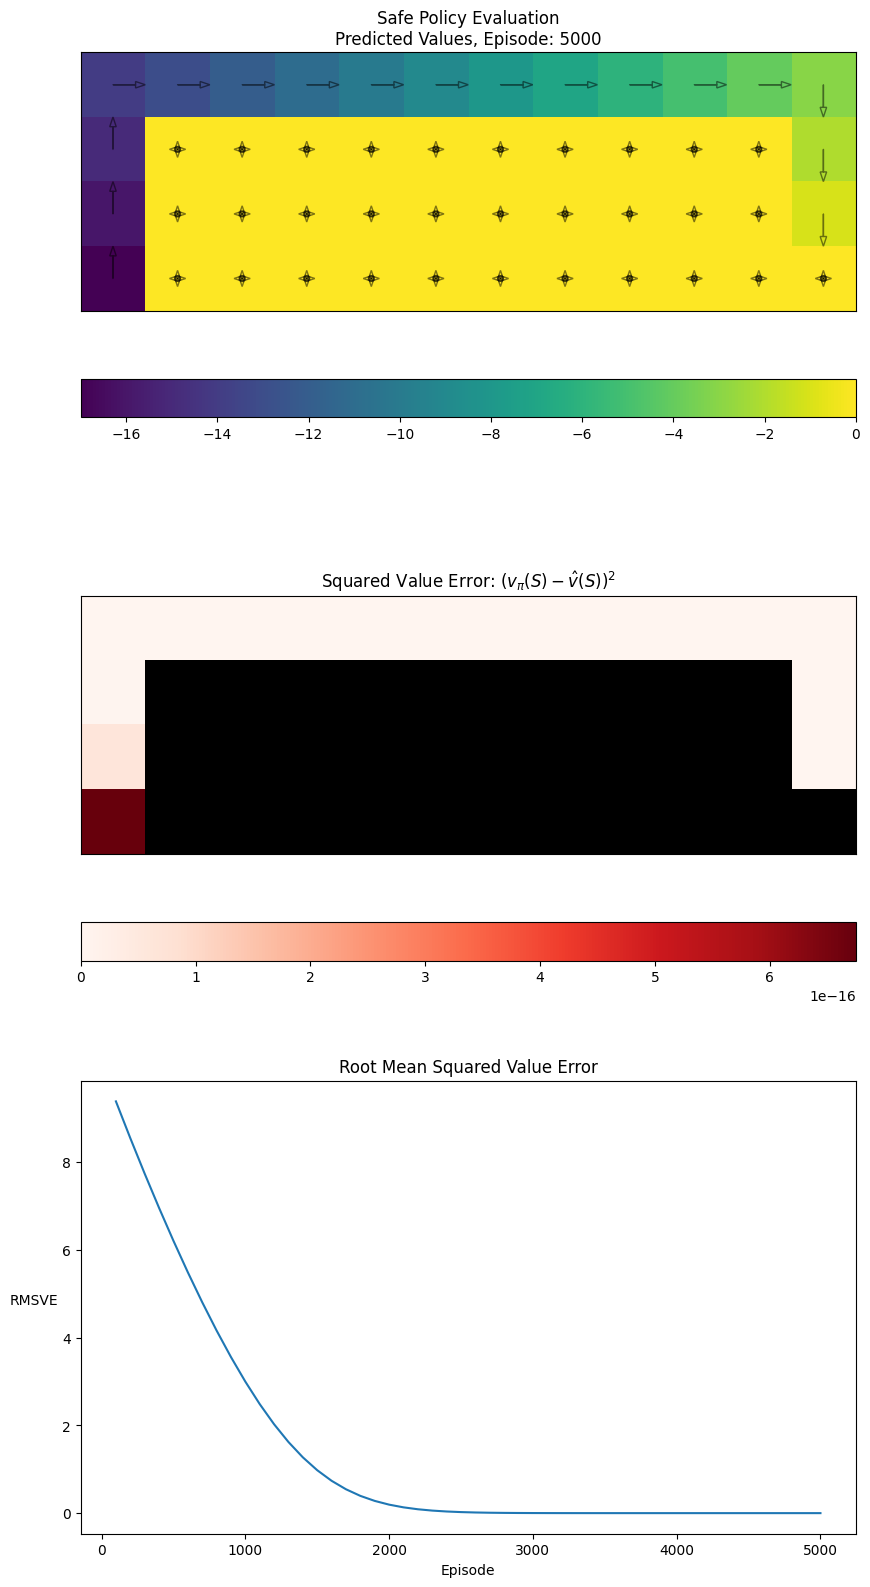

In [31]:

# Run policy evaluation experiment with specified parameters for the safe policy
values = run_experiment(
    env_info,
    agent_info,
    num_episodes=5000,
    experiment_name="Safe Policy Evaluation",
    plot_freq=100,
    true_values_file=true_values_file
)

### **Policy Evaluation of a Near Optimal Stochastic Policy**

Now, we try a stochastic policy that deviates a little from the optimal policy seen above. This means we can get different results due to randomness. We will thus average the value function estimates we get over multiple runs. This can take some time, upto about 5 minutes from previous testing.

In [33]:
# Policy Setup for Partially Deterministic Cliff Walk Environment

# Define environment parameters with standard Cliff Walk dimensions
env_info = {"grid_height": 4, "grid_width": 12}

# Define agent parameters: discount factor and initial step size
agent_info = {"discount": 1, "step_size": 0.01}

# Initialize a policy with uniform random actions
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25

# Make the starting state (state 36) mostly deterministic (90% UP)
policy[36] = [0.9, 0.03, 0.03, 0.04]

# Set states along the cliff edge (states 24 to 34) to favor moving RIGHT (90% probability)
for state in range(24, 35):
    policy[state] = [0.03, 0.03, 0.04, 0.9]

# Set state 35 to favor moving DOWN (90% probability), transitioning toward the goal
policy[35] = [0.03, 0.03, 0.9, 0.04]

# Update agent parameters with the defined policy and step size
agent_info.update({"policy": policy})
agent_info.update({"step_size": 0.01})

# Set fixed random seed for reproducibility
agent_info["seed"] = 0

# Path to file containing true state-value function for comparison purposes
true_values_file = "/content/env/optimal_policy_value_fn.npy"



Running Episodes: 100%|██████████| 5000/5000 [00:24<00:00, 203.21it/s]


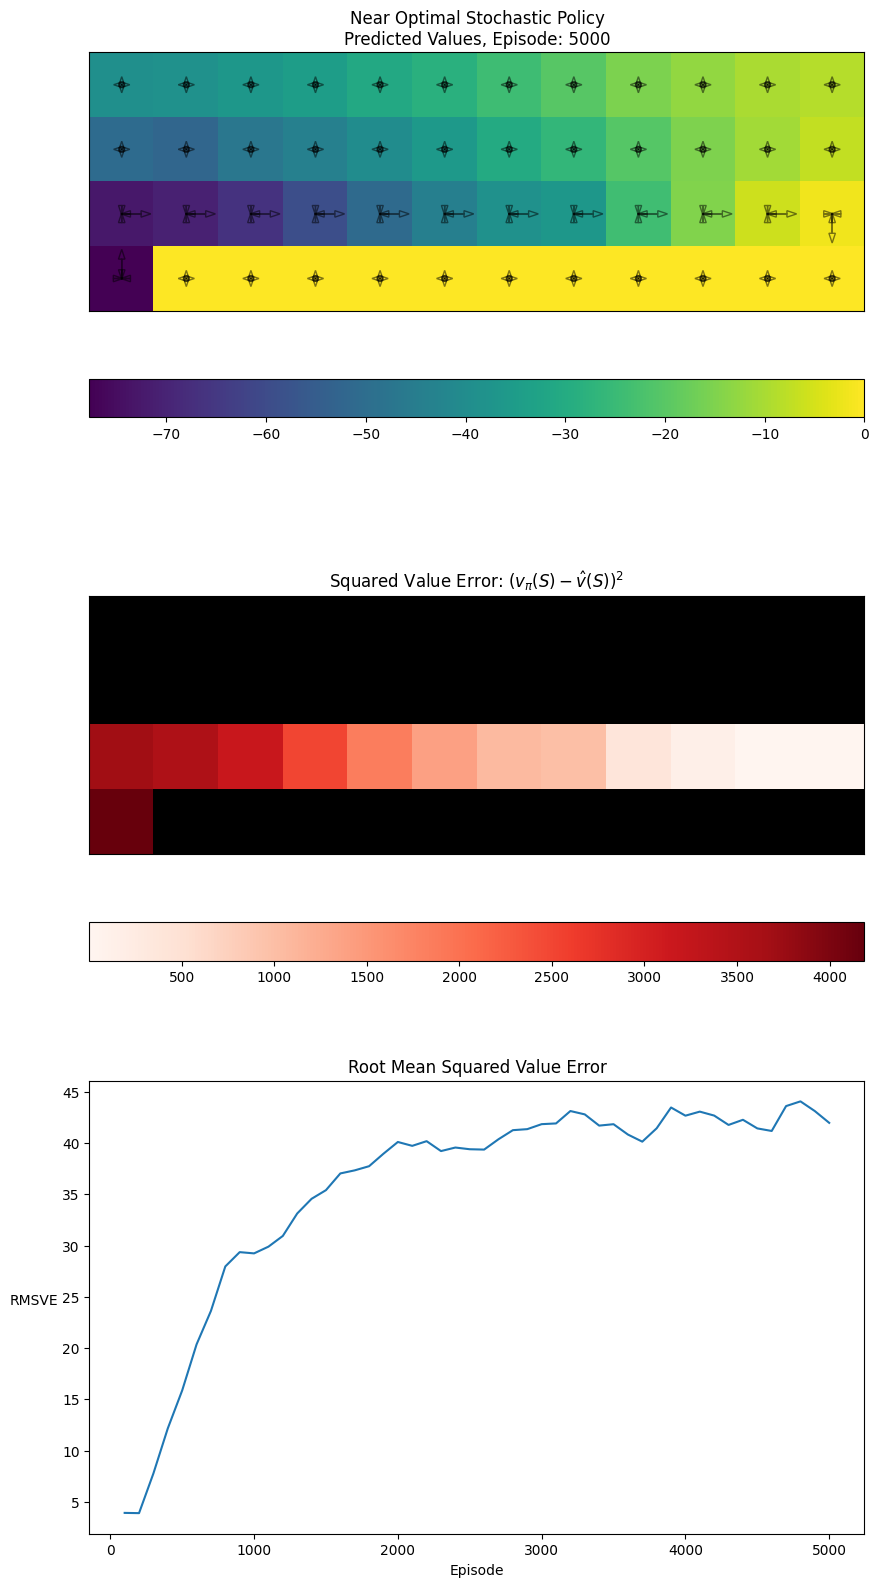

In [34]:

# Run the policy evaluation experiment with specified parameters
values = run_experiment(
    env_info,
    agent_info,
    num_episodes=5000,
    experiment_name="Near Optimal Stochastic Policy",
    plot_freq=100,
    true_values_file=true_values_file
)

## **Conclusion**
Congratulations, you have completed assignment 6! In this assignment, we investigated a very useful concept for sample-based online learning: temporal difference. We particularly looked at the prediction problem where the goal is to find the value function corresponding to a given policy. In the next assignment, by learning the action-value function instead of the state-value function, you will get to see how temporal difference learning can be used in control as well.